# Airline-Satisfaction-Prediction


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
df_tr = pd.read_csv('train_cleaned.csv')
df_te = pd.read_csv('test_cleaned.csv')

# drop un_named
df_tr.drop(df_tr.columns[0], axis=1, inplace=True)
df_te.drop(df_te.columns[0], axis=1, inplace=True)

In [3]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 24 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103904 non-null  int64  
 1   Customer Type                      103904 non-null  int64  
 2   Age                                103904 non-null  int64  
 3   Type of Travel                     103904 non-null  int64  
 4   Flight Distance                    103904 non-null  int64  
 5   Inflight wifi service              103904 non-null  int64  
 6   Departure/Arrival time convenient  103904 non-null  int64  
 7   Ease of Online booking             103904 non-null  int64  
 8   Gate location                      103904 non-null  int64  
 9   Food and drink                     103904 non-null  int64  
 10  Online boarding                    103904 non-null  int64  
 11  Seat comfort                       1039

In [4]:
df_tr.head()

,Gender,Customer Type,Age,Type of Travel,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,...,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,satisfaction,Class_Business,Class_Eco,Class_Eco Plus
0,0,1,13,1,460,3,4,3,1,5,...,3,4,4,5,5,25,0,0.0,0.0,1.0
1,0,0,25,0,235,3,2,3,3,1,...,5,3,1,4,1,1,0,1.0,0.0,0.0
2,1,1,26,0,1142,2,2,2,2,5,...,3,4,4,4,5,0,1,1.0,0.0,0.0
3,1,1,25,0,562,2,5,5,5,2,...,5,3,1,4,2,11,0,1.0,0.0,0.0
4,0,1,61,0,214,3,3,3,3,4,...,4,4,3,3,3,0,1,1.0,0.0,0.0


###

### Principal Component Analysis

It is possible for the model to overfit, with 24 features for 100k+ records and correlations between features. Diemsionality redcution can be useful to address the issue.

In [9]:
# scale before pca
scaler = StandardScaler().set_output(transform="pandas")

df_tr_scaled = scaler.fit_transform(df_tr.drop('satisfaction', axis=1))

n_cps = 10
pca = PCA(n_components=n_cps)
df_tr_pca = pca.fit_transform(df_tr_scaled)
print('Top {} PCs explained {}% of the variance on training data'.format(n_cps, round(sum(pca.explained_variance_ratio_)*100 ,2) ) )

Top 10 PCs explained 77.43% of the variance on training data


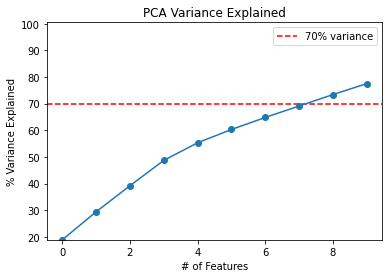

In [10]:
variance = pca.explained_variance_ratio_ #c
var=np.cumsum(np.round(variance, decimals=3)*100)

plt. ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Variance Explained' )
plt.ylim(min(var),100.5)
plt.style.context('seaborn-whitegrid')
plt.axhline(y=70, color='r', linestyle='--', label='70% variance')
plt.legend()
plt.plot(var, '-o' ,label='cumulative variance')
plt.show()

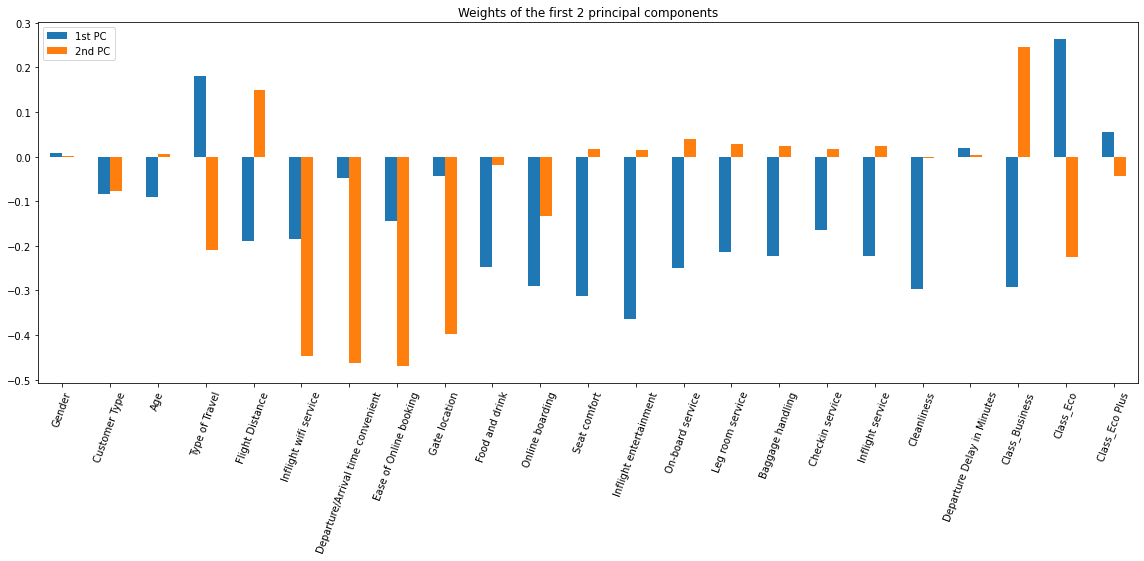

In [11]:
first_pca_component = pd.DataFrame(
    pca.components_[0], index=df_tr_scaled.columns, columns=["1st PC"])
first_pca_component["2nd PC"] =  pca.components_[1]
first_pca_component.plot.bar(
    title="Weights of the first 2 principal components", figsize=(16, 8)
)
_ = plt.tight_layout()
plt.xticks(rotation=70)
plt.show()

@xyn 你来再解释一下

1st PC: customers whose `Type of Travel` leans towards personal travel, likely not traveling on `Class_Business`, 'service quality' features such as `Seat Comfort` and `Inflight Entertainmennt` are largely negative, and travel more on `class_Eco`; -> non-business, picky, and economic

2nd PC: customers whose `Type of Travel` leans towards business travel, have longer `Flight Distance` is larger, travels more on `Class Business`, and compared with the first group they are even more picky on  'effieciency' such as `Depature/Arrival time convenient` and `xxx` -> business people who valued efficiency yet less so on leisure

In [12]:
# apply pca on test set
df_te_scaled = scaler.fit_transform(df_te.drop('satisfaction', axis=1))
df_te_pca = pca.transform(df_te_scaled)

In [13]:
# without pca
train_x = df_tr.drop('satisfaction', axis=1)
train_y = df_tr['satisfaction']
test_x =  df_te.drop('satisfaction', axis=1)
test_y =  df_te['satisfaction']

# with pca
train_x_pca = df_tr_pca
test_x_pca = df_te_pca

### Logistic Regression


We use cross validation to pick the best C for Logistic Rregression.

In [58]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

# l1 regularization without PCA
logreg_l1_cv = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000)
grid_search_l1 = GridSearchCV(logreg_l1_cv, param_grid, cv=5)
grid_search_l1.fit(train_x, train_y)

best_model_l1 = grid_search_l1.best_estimator_
test_pred_l1 = best_model_l1.predict(test_x)

print("Best C for L1 regularization:", grid_search_l1.best_params_)
print("Best training accuracy with L1 regularization: {:.2f}%".format(grid_search_l1.best_score_ * 100))
print('Testing accuracy with L1 regularization without PCA: {:.2f}%'.format(accuracy_score(test_y, test_pred_l1) * 100))

# l2 regularization without PCA
logreg_l2_cv = LogisticRegression(penalty='l2', max_iter=2000)
grid_search_l2 = GridSearchCV(logreg_l2_cv, param_grid, cv=5)
grid_search_l2.fit(train_x, train_y)

best_model_l2 = grid_search_l2.best_estimator_
test_pred_l2 = best_model_l2.predict(test_x)

print("Best C for L2 regularization:", grid_search_l2.best_params_)
print("Best training accuracy with L2 regularization: {:.2f}%".format(grid_search_l2.best_score_ * 100))
print('Testing accuracy with L2 regularization without PCA: {:.2f}%'.format(accuracy_score(test_y, test_pred_l2) * 100))

Best C for L1 regularization: {'C': 10}
Best training accuracy with L1 regularization: 87.49%
Testing accuracy with L1 regularization without PCA: 87.16%


/Users/summerxiao/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/summerxiao/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

Best C for L2 regularization: {'C': 0.1}
Best training accuracy with L2 regularization: 87.49%
Testing accuracy with L2 regularization without PCA: 87.12%


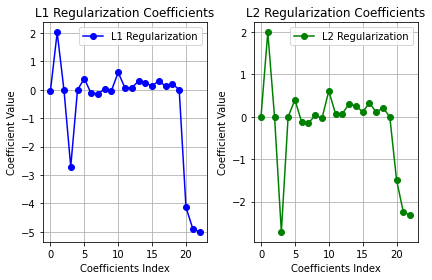

In [61]:
coefficients_l1 = best_model_l1.coef_[0]
coefficients_l2 = best_model_l2.coef_[0]
# Plotting L1 coefficients
plt.subplot(1, 2, 1)
plt.plot(coefficients_l1, color='blue', marker='o', linestyle='-', label='L1 Regularization')
plt.title('L1 Regularization Coefficients')
plt.xlabel('Coefficients Index')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.legend()

# Plotting L2 coefficients
plt.subplot(1, 2, 2)
plt.plot(coefficients_l2, color='green', marker='o', linestyle='-', label='L2 Regularization')
plt.title('L2 Regularization Coefficients')
plt.xlabel('Coefficients Index')
plt.ylabel('Coefficient Value')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

Try with PCA:

In [39]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}

# l1 regularization with PCA
logreg_l1_cv = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000)
grid_search_l1_pca = GridSearchCV(logreg_l1_cv, param_grid, cv=5)
grid_search_l1_pca.fit(train_x_pca, train_y)

best_model_l1_pca = grid_search_l1_pca.best_estimator_
test_pred_l1_pca = best_model_l1_pca.predict(test_x_pca)

print("Best C for L1 regularization with PCA:", grid_search_l1_pca.best_params_)
print("Best training accuracy with L1 regularization and PCA: {:.2f}%".format(grid_search_l1_pca.best_score_ * 100))
print('Testing accuracy with L1 regularization without PCA: {:.2f}%'.format(accuracy_score(test_y, test_pred_l1_pca) * 100))

# l2 regularization with PCA
logreg_l2_cv = LogisticRegression(penalty='l2', max_iter=5000)
grid_search_l2_pca = GridSearchCV(logreg_l2_cv, param_grid, cv=5)
grid_search_l2_pca.fit(train_x_pca, train_y)

best_model_l2_pca = grid_search_l2_pca.best_estimator_
test_pred_l2_pca = best_model_l2_pca.predict(test_x_pca)

print("Best C for L2 regularization with PCA:", grid_search_l2_pca.best_params_)
print("Best training accuracy with L2 regularization and PCA: {:.2f}%".format(grid_search_l2_pca.best_score_ * 100))
print('Testing accuracy with L2 regularization without PCA: {:.2f}%'.format(accuracy_score(test_y, test_pred_l2_pca) * 100))

Best C for L1 regularization with PCA: {'C': 10}
Best training accuracy with L1 regularization and PCA: 84.67%
Testing accuracy with L1 regularization without PCA: 84.36%
Best C for L2 regularization with PCA: {'C': 0.1}
Best training accuracy with L2 regularization and PCA: 84.68%
Testing accuracy with L2 regularization without PCA: 84.35%


After picking the best parameter for each case and looking at the test accuray, we found they are roughly the same. Let's try to have different number of components in PCA.

Try 12 PCs

In [41]:
n_cps = 12
pca_12 = PCA(n_components=n_cps)
df_tr_pca_12 = pca_12.fit_transform(df_tr_scaled)
print('Top {} PCs explained {}% of the variance on training data'.format(n_cps, round(sum(pca_12.explained_variance_ratio_)*100 ,2) ) )


Top 12 PCs explained 84.03% of the variance on training data


In [42]:
# apply pca on test set
df_te_pca_12 = pca_12.transform(df_te_scaled)

# with pca
train_x_pca_12 = df_tr_pca_12
test_x_pca_12 = df_te_pca_12

In [45]:
# l1 regularization with 12 PCs
logreg_l1_cv = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000)
grid_search_l1_12 = GridSearchCV(logreg_l1_cv, param_grid, cv=5)
grid_search_l1_12.fit(train_x_pca_12, train_y)

best_model_l1_12 = grid_search_l1_12.best_estimator_
test_pred_l1_12 = best_model_l1_12.predict(test_x_pca_12)

print("Best C for L1 regularization with 12 PCs:", grid_search_l1_12.best_params_)
print("Best training accuracy with L1 regularization and 12 PCs: {:.2f}%".format(grid_search_l1_12.best_score_ * 100))
print('Testing accuracy with L1 regularization with 12 PCs: {:.2f}%'.format(accuracy_score(test_y, test_pred_l1_12) * 100))

# l2 regularization with 12 PCs
logreg_l2_cv = LogisticRegression(penalty='l2', max_iter=5000)
grid_search_l2_12 = GridSearchCV(logreg_l2_cv, param_grid, cv=5)
grid_search_l2_12.fit(train_x_pca_12, train_y)

best_model_l2_12 = grid_search_l2_12.best_estimator_
test_pred_l2_12 = best_model_l2_12.predict(test_x_pca_12)

print("Best C for L2 regularization with 12 PCs:", grid_search_l2_12.best_params_)
print("Best training accuracy with L2 regularization and 12 PCs: {:.2f}%".format(grid_search_l2_12.best_score_ * 100))
print('Testing accuracy with L2 regularization with 12 PCs: {:.2f}%'.format(accuracy_score(test_y, test_pred_l2_12) * 100))

Best C for L1 regularization with 12 PCs: {'C': 0.1}
Best training accuracy with L1 regularization and 12 PCs: 84.94%
Testing accuracy with L1 regularization with 12 PCs: 84.63%
Best C for L2 regularization with 12 PCs: {'C': 1}
Best training accuracy with L2 regularization and 12 PCs: 84.94%
Testing accuracy with L2 regularization with 12 PCs: 84.62%


Try 8 PCs

In [51]:
n_cps = 8
pca_8 = PCA(n_components=n_cps)
df_tr_pca_8 = pca_8.fit_transform(df_tr_scaled)
print('Top {} PCs explained {}% of the variance on training data'.format(n_cps, round(sum(pca_8.explained_variance_ratio_)*100 ,2) ) )

Top 8 PCs explained 69.08% of the variance on training data


In [52]:
# apply pca on test set
df_te_pca_8 = pca_8.transform(df_te_scaled)

# with pca
train_x_pca_8 = df_tr_pca_8
test_x_pca_8 = df_te_pca_8

In [53]:
# l1 regularization with 8 PCs
logreg_l1_cv = LogisticRegression(penalty='l1', solver='liblinear', max_iter=5000)
grid_search_l1_8 = GridSearchCV(logreg_l1_cv, param_grid, cv=5)
grid_search_l1_8.fit(train_x_pca_8, train_y)

best_model_l1_8 = grid_search_l1_8.best_estimator_
test_pred_l1_8 = best_model_l1_8.predict(test_x_pca_8)

print("Best C for L1 regularization with 8 PCs:", grid_search_l1_8.best_params_)
print("Best training accuracy with L1 regularization and 8 PCs: {:.2f}%".format(grid_search_l1_8.best_score_ * 100))
print('Testing accuracy with L1 regularization with 8 PCs: {:.2f}%'.format(accuracy_score(test_y, test_pred_l1_8) * 100))

# l2 regularization with 8 PCs
logreg_l2_cv = LogisticRegression(penalty='l2', max_iter=5000)
grid_search_l2_8 = GridSearchCV(logreg_l2_cv, param_grid, cv=5)
grid_search_l2_8.fit(train_x_pca_8, train_y)

best_model_l2_8 = grid_search_l2_8.best_estimator_
test_pred_l2_8 = best_model_l2_8.predict(test_x_pca_8)

print("Best C for L2 regularization with 8 PCs:", grid_search_l2_8.best_params_)
print("Best training accuracy with L2 regularization and 8 PCs: {:.2f}%".format(grid_search_l2_8.best_score_ * 100))
print('Testing accuracy with L2 regularization with 8 PCs: {:.2f}%'.format(accuracy_score(test_y, test_pred_l2_8) * 100))

Best C for L1 regularization with 8 PCs: {'C': 0.01}
Best training accuracy with L1 regularization and 8 PCs: 83.62%
Testing accuracy with L1 regularization with 8 PCs: 83.16%
Best C for L2 regularization with 8 PCs: {'C': 0.001}
Best training accuracy with L2 regularization and 8 PCs: 83.61%
Testing accuracy with L2 regularization with 8 PCs: 83.20%


From the result above, we can conclude that Logistic Regression is not the best method for our classification problem.

Possible reason why our l1/l2 regularization give similar accuracy:


*   A number of features are discrete
*   The presence of correlated features can affect how L1 and L2 regularization behave
*   Logistic regression is a relatively simple model compared to more complex models like neural networks. As a result, the impact of regularization on model performance may not vary drastically between L1 and L2 regularization.



### Support Vector Machine

In [25]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [26]:
# without pca
clf_svm = svm.SVC().fit(train_x, train_y)

In [27]:
print('training accuracy on svm without pca: {:.2f}%'.format(accuracy_score(train_y, clf_svm.predict(train_x)) * 100))
print('testing accuracy on svm without pca: {:.2f}%'.format(accuracy_score(test_y, clf_svm.predict(test_x))* 100))

In [ ]:
# with pca
clf_svm_pca = svm.SVC(kernel='rbf').fit(train_x_pca, train_y)

In [ ]:
print('training accuracy on svm with pca: {:.2f}%'.format(accuracy_score(train_y, clf_svm_pca.predict(train_x_pca)) * 100))
print('testing accuracy on svm with pca: {:.2f}%'.format(accuracy_score(test_y, clf_svm_pca.predict(test_x_pca)) * 100))

training accuracy on svm with pca: 92.39%
testing accuracy on svm with pca: 92.28%


Visualize the points on pc1 and pc2, decision boundary seems non-linear.

Which is why we used a rbf kernal to transform the data, and we need  to try non-linear methods.

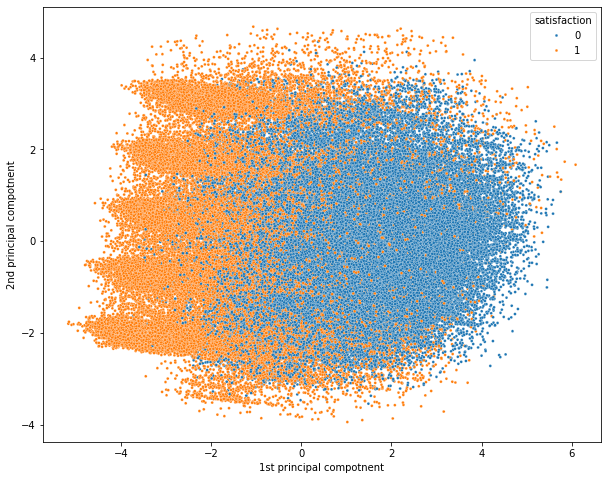

In [ ]:
plt.figure(figsize=(10, 8))
# Plotting our two-features-space
sns.scatterplot(x=train_x_pca[:, 0],
                y=train_x_pca[:, 1],
                hue=train_y,
                s=8)
plt.xlabel('1st principal compotnent')
plt.ylabel('2nd principal compotnent')
plt.show()


### Decision Trees: Random Forest and XGBoost

In [32]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, validation_curve
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import plot_tree

import sys
sys.path.append('/Users/summerxiao/myenv/lib/python3.8/site-packages')

import shap
shap.initjs()

In [14]:
def run(model, X_train, y_train, X_test, y_test):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, pred)

    cm = confusion_matrix(y_test, pred, labels = model.classes_)
    acc = accuracy_score(test_y, pred)

    d = ConfusionMatrixDisplay(cm, display_labels = model.classes_)
    d.plot()
    print("ROC_AUC = {:.2f}".format(roc_auc))
    print("Accuracy = {:.2f}%".format(acc*100))
    print(classification_report(y_test, pred, digits=2))

    return model, roc_auc

def plot_validation_curve(estimator, X, y, param_name, param_range, cv=5, scoring="accuracy"):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=-1)

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(param_range, train_mean, label="Training score", color="darkorange")
    plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="darkorange", alpha=0.2)
    plt.plot(param_range, test_mean, label="Cross-validation score", color="navy")
    plt.fill_between(param_range, test_mean - test_std, test_mean + test_std, color="navy", alpha=0.2)

    plt.title(f"Validation Curve with Random Forest ({param_name})")
    plt.xlabel(param_name)
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.show()

In [15]:
rf = RandomForestClassifier(random_state=5741)

param_grid = {
    'n_estimators': [100, 200, 300],   # Number of trees in the forest
    'max_features': [4, 5],   # Maximum number of features
    'max_depth': [10, 20],   # Maximum number of levels in tree
    'min_samples_split': [10, 20],    # Minimum number of samples required to split a node
    'min_samples_leaf': [50, 100]   # Minimum numbers of samples per leaf
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=0, n_jobs=-1)

grid_search.fit(train_x, train_y)

best_rf_par = grid_search.best_params_
best_rf_model = grid_search.best_estimator_

print("Best parameters found: ", best_rf_par)

Best parameters found:  {'max_depth': 20, 'max_features': 5, 'min_samples_leaf': 50, 'min_samples_split': 10, 'n_estimators': 200}


In [16]:
accuracy_score(train_y, best_rf_model.predict(train_x))

0.9473744995380351

ROC_AUC = 0.94
Accuracy = 94.59%
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     14573
           1       0.95      0.93      0.94     11403

    accuracy                           0.95     25976
   macro avg       0.95      0.94      0.94     25976
weighted avg       0.95      0.95      0.95     25976



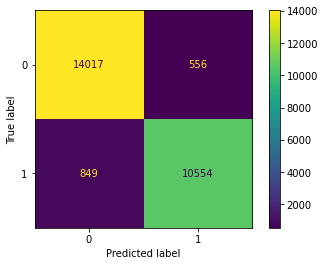

In [17]:
model_rf, roc_auc_rf = run(best_rf_model, train_x, train_y, test_x, test_y)

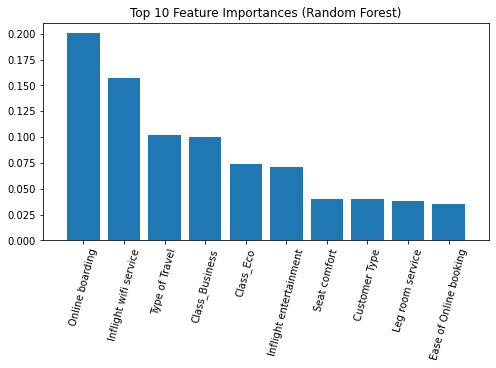

In [18]:
importances_rf = best_rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1][:10]

plt.figure(figsize=(8, 4))
plt.title("Top 10 Feature Importances (Random Forest)")
plt.bar(range(len(indices_rf)), importances_rf[indices_rf])
plt.xticks(range(len(indices_rf)), train_x.columns[indices_rf], rotation=75)
plt.xlim([-1, len(indices_rf)])
plt.show()

Here, we take a quick look at how the change of some of the parameters of our random forest model affects the accuracy.

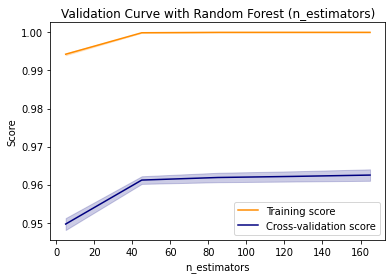

In [19]:
plot_validation_curve(RandomForestClassifier(random_state=5741), train_x, train_y, "n_estimators", np.arange(5, 205, 40))

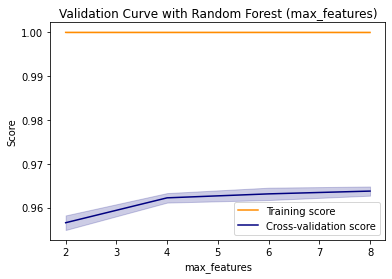

In [20]:
plot_validation_curve(RandomForestClassifier(random_state=5741), train_x, train_y, "max_features", np.arange(2, 10, 2))

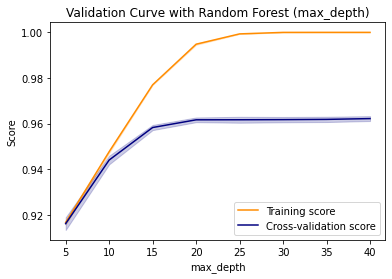

In [21]:
plot_validation_curve(RandomForestClassifier(random_state=5741), train_x, train_y, "max_depth", np.arange(5, 45, 5))

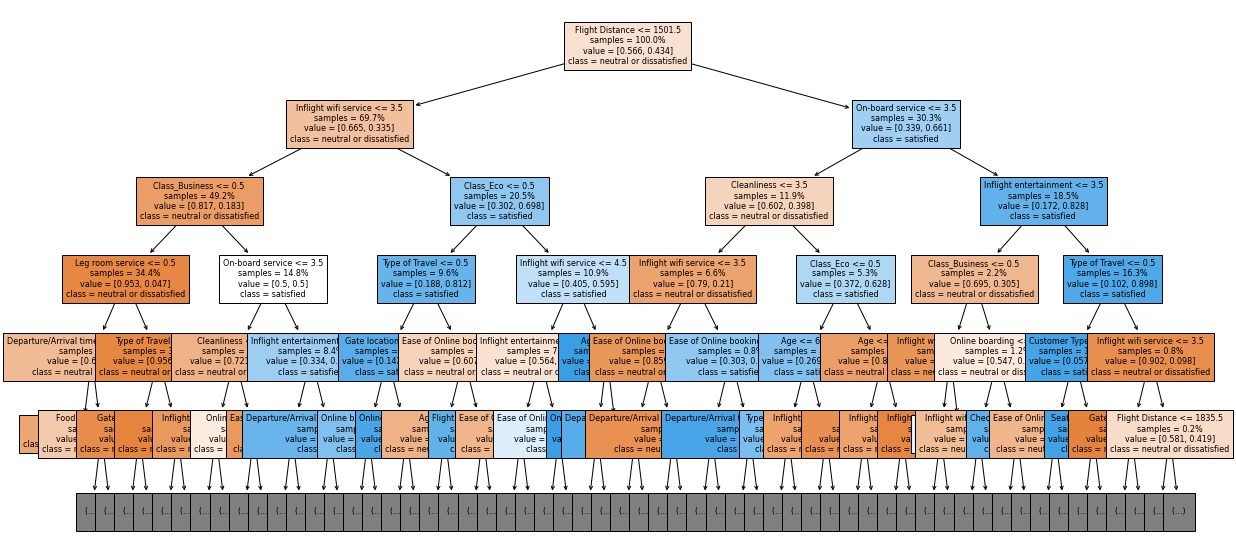

In [22]:
plt.figure(figsize=(20,10))
plot_tree(best_rf_model.estimators_[0], filled=True, feature_names=train_x.columns, class_names=['neutral or dissatisfied', 'satisfied'],
          impurity=False, proportion=True, max_depth=5, fontsize=8)
plt.show()

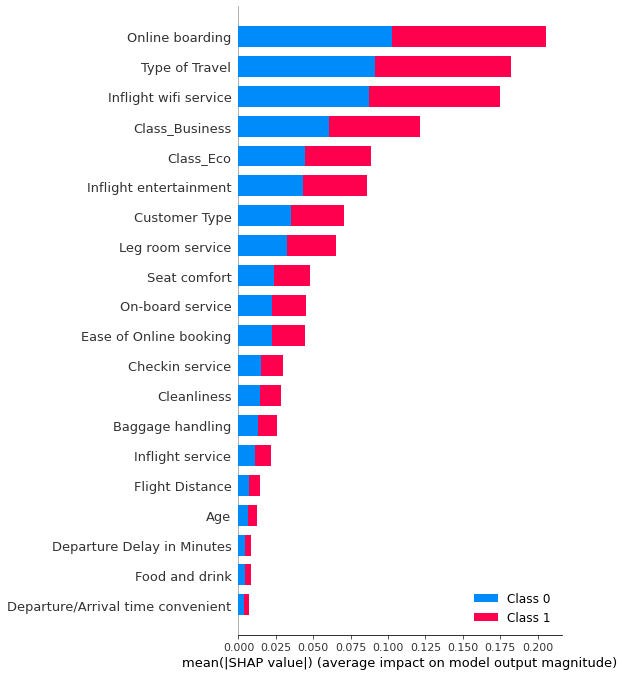

In [23]:
explainer = shap.Explainer(best_rf_model)
shap_values = explainer.shap_values(test_x)
shap.summary_plot(shap_values, test_x)

In [33]:
xgb = xgb.XGBClassifier(random_state=5741)

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9]
}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, verbose=0, n_jobs=-1)

grid_search.fit(train_x, train_y)
best_xgb_par = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

print("Best parameters found: ", best_xgb_par)

Best parameters found:  {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.9}


In [34]:
accuracy_score(train_y, best_xgb_model.predict(train_x))

0.9829939174622728

ROC_AUC = 0.96
Accuracy = 96.46%
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     14573
           1       0.97      0.95      0.96     11403

    accuracy                           0.96     25976
   macro avg       0.97      0.96      0.96     25976
weighted avg       0.96      0.96      0.96     25976



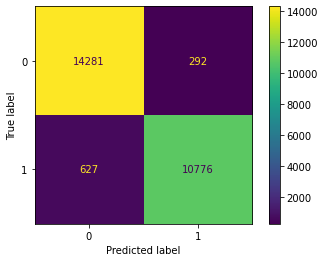

In [35]:
model_xgb, roc_auc_xgb = run(best_xgb_model, train_x, train_y, test_x, test_y)

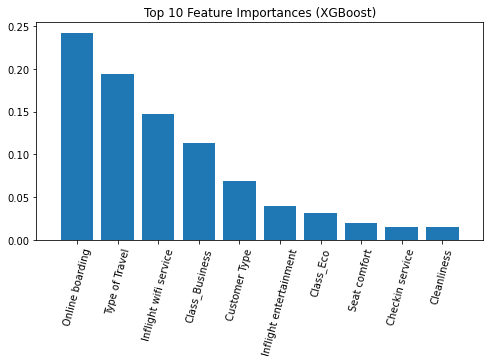

In [36]:
importances_xgb = best_xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1][:10]

plt.figure(figsize=(8, 4))
plt.title("Top 10 Feature Importances (XGBoost)")
plt.bar(range(len(indices_xgb)), importances_xgb[indices_xgb])
plt.xticks(range(len(indices_xgb)), train_x.columns[indices_xgb], rotation=75)
plt.xlim([-1, len(indices_xgb)])
plt.show()

In [ ]:
# xgb.plot_tree(best_xgb_model, num_trees=0, rankdir='LR')
# plt.show()

# xgb.plot_tree(best_xgb_model, num_trees=49)
# plt.rcParams['figure.figsize'] = [20, 10]
# plt.show()

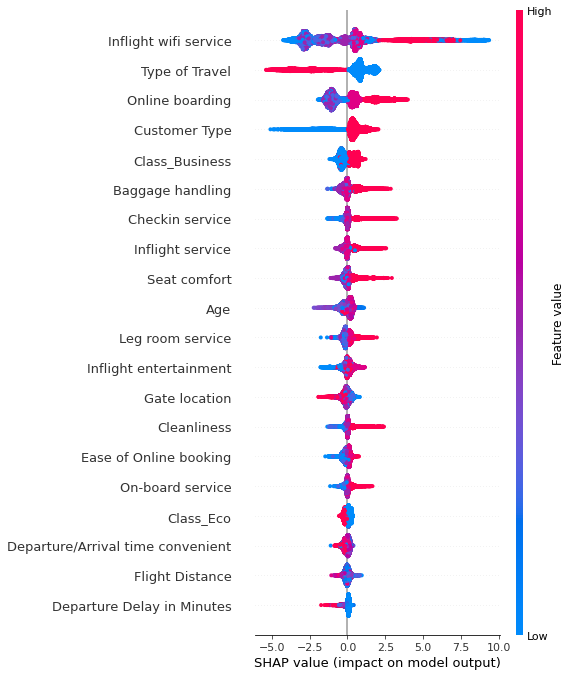

In [37]:
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer.shap_values(test_x)
shap.summary_plot(shap_values, test_x)